# Chemeleon: Generative AI for Crystal Structure Discovery

In this notebook, we'll explore how to use Chemeleon for generating crystal structures. We'll cover:

1. Crystal Structure Prediction (CSP) - generating structures for specific formulas
2. De Novo Generation (DNG) - generating novel structures without constraints
3. Analyzing and visualising the generated structures
4. Comparing with traditional structure prediction methods

## Important Notes:

- **Chemeleon Installation**: This notebook assumes you have Chemeleon installed. If not, it will create example structures for demonstration purposes.
- **Computational Requirements**: Chemeleon requires significant computational resources. The examples here use CPU mode for compatibility.
- **Example Data**: If Chemeleon commands fail to run, the notebook will automatically create example structures so you can still follow along with the analysis and visualisation techniques.

## Setup and Installation

In [18]:
# First, let's check if we're in Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")
    # Clone the Chemeleon repository
    !git clone https://github.com/hspark1212/chemeleon-dng.git
    %cd chemeleon-dng
    !pip install -e .
else:
    print("Running locally")
    # Ensure you have the package installed locally
    # You should have already cloned and installed chemeleon-dng

Running locally


In [19]:
# Import required libraries
import os
import sys
import glob
import tempfile
import subprocess
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Structure, Composition
from pymatgen.analysis.structure_matcher import StructureMatcher
from pymatgen.io.cif import CifWriter
import warnings
warnings.filterwarnings('ignore')

# Visualisation libraries
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.express as px
    PLOTLY_AVAILABLE = True
    print("Plotly available for 3D visualisation")
except ImportError:
    PLOTLY_AVAILABLE = False
    print("Plotly not available - falling back to matplotlib")

try:
    import pymatviz as pmv
    PYMATVIZ_AVAILABLE = True
    print("Pymatviz available for structure visualisation")
except ImportError:
    PYMATVIZ_AVAILABLE = False
    print("Pymatviz not available - using basic matplotlib")

# Add chemeleon-dng to path if running locally
if not IN_COLAB:
    chemeleon_path = Path('/home/ryan/informatics/chemeleon-dng')
    if chemeleon_path.exists():
        sys.path.insert(0, str(chemeleon_path))

print("Libraries imported successfully!")

Plotly available for 3D visualisation
Pymatviz available for structure visualisation
Libraries imported successfully!


In [20]:
# Define functions for visualising crystal structures

def plot_structure_3d(structure, title="Crystal Structure"):
    """
    Create interactive 3D visualisation of crystal structure using Plotly
    """
    if not PLOTLY_AVAILABLE:
        print("Plotly not available - cannot create 3D plot")
        return None
    
    # Get atomic positions and species
    coords = structure.cart_coords
    species = [str(site.specie) for site in structure.sites]
    
    # Create colour map for elements
    unique_species = list(set(species))
    colours = px.colors.qualitative.Set1[:len(unique_species)]
    colour_map = dict(zip(unique_species, colours))
    
    # Create 3D scatter plot
    fig = go.Figure()
    
    for specie in unique_species:
        # Filter coordinates for this species
        mask = [s == specie for s in species]
        specie_coords = coords[mask]
        
        fig.add_trace(go.Scatter3d(
            x=specie_coords[:, 0],
            y=specie_coords[:, 1],
            z=specie_coords[:, 2],
            mode='markers',
            marker=dict(
                size=8,
                color=colour_map[specie],
                symbol='circle'
            ),
            name=specie,
            text=[f"{specie}_{i}" for i in range(len(specie_coords))],
            hovertemplate='%{text}<br>x: %{x:.2f}<br>y: %{y:.2f}<br>z: %{z:.2f}'
        ))
    
    # Add unit cell edges
    lattice = structure.lattice
    vertices = [
        [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0], [0, 0, 0],  # bottom face
        [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1], [0, 0, 1],  # top face
    ]
    
    # Convert fractional to cartesian coordinates
    cart_vertices = []
    for vertex in vertices:
        cart_coord = lattice.get_cartesian_coords(vertex)
        cart_vertices.append(cart_coord)
    
    cart_vertices = np.array(cart_vertices)
    
    # Add unit cell outline
    fig.add_trace(go.Scatter3d(
        x=cart_vertices[:, 0],
        y=cart_vertices[:, 1],
        z=cart_vertices[:, 2],
        mode='lines',
        line=dict(color='black', width=2),
        name='Unit Cell',
        showlegend=False
    ))
    
    # Additional edges to complete the wireframe
    edges = [
        ([0, 0, 0], [0, 0, 1]),  # vertical edges
        ([1, 0, 0], [1, 0, 1]),
        ([1, 1, 0], [1, 1, 1]),
        ([0, 1, 0], [0, 1, 1])
    ]
    
    for edge in edges:
        edge_cart = [lattice.get_cartesian_coords(point) for point in edge]
        edge_cart = np.array(edge_cart)
        fig.add_trace(go.Scatter3d(
            x=edge_cart[:, 0],
            y=edge_cart[:, 1],
            z=edge_cart[:, 2],
            mode='lines',
            line=dict(color='black', width=2),
            showlegend=False
        ))
    
    fig.update_layout(
        title=f"{title}<br>{structure.composition.reduced_formula} - Space Group: {structure.get_space_group_info()[0]}",
        scene=dict(
            xaxis_title='X (Å)',
            yaxis_title='Y (Å)',
            zaxis_title='Z (Å)',
            aspectmode='cube'
        ),
        showlegend=True,
        width=800,
        height=600
    )
    
    return fig

def plot_multiple_structures(structures, titles=None):
    """
    Plot multiple structures side by side for comparison
    """
    if PYMATVIZ_AVAILABLE:
        # Use pymatviz for clean 2D visualisation
        if titles is None:
            titles = [f"Structure {i+1}" for i in range(len(structures))]
        
        # Create subplot for each structure
        n_structs = len(structures)
        n_cols = min(3, n_structs)
        n_rows = (n_structs + n_cols - 1) // n_cols
        
        fig, axes = pmv.structure_2d(structures, n_cols=n_cols)
        
        # Add custom titles
        for i, (ax, title) in enumerate(zip(axes.flat, titles)):
            if i < len(structures):
                comp = structures[i].composition.reduced_formula
                sg = structures[i].get_space_group_info()[0]
                ax.set_title(f"{title}\n{comp} (SG: {sg})")
        
        plt.tight_layout()
        return fig
    else:
        # Fallback to basic matplotlib
        n_structs = len(structures)
        n_cols = min(3, n_structs)
        n_rows = (n_structs + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_structs == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, structure in enumerate(structures):
            row, col = i // n_cols, i % n_cols
            ax = axes[row, col] if n_rows > 1 else axes[col]
            
            # Simple atomic position plot
            coords = structure.cart_coords
            species = [str(site.specie) for site in structure.sites]
            
            for specie in set(species):
                mask = [s == specie for s in species]
                specie_coords = coords[mask]
                ax.scatter(specie_coords[:, 0], specie_coords[:, 1], 
                          label=specie, s=50, alpha=0.7)
            
            ax.set_xlabel('X (Å)')
            ax.set_ylabel('Y (Å)')
            comp = structure.composition.reduced_formula
            title = titles[i] if titles else f"Structure {i+1}"
            ax.set_title(f"{title}\n{comp}")
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Hide empty subplots
        for i in range(n_structs, n_rows * n_cols):
            row, col = i // n_cols, i % n_cols
            ax = axes[row, col] if n_rows > 1 else axes[col]
            ax.set_visible(False)
        
        plt.tight_layout()
        return fig

def analyse_structure_diversity(structures):
    """
    Analyse the diversity of generated structures
    """
    compositions = []
    space_groups = []
    volumes_per_atom = []
    densities = []
    
    for structure in structures:
        compositions.append(structure.composition.reduced_formula)
        space_groups.append(structure.get_space_group_info()[0])
        volumes_per_atom.append(structure.volume / len(structure))
        densities.append(structure.density)
    
    analysis = {
        'total_structures': len(structures),
        'unique_compositions': len(set(compositions)),
        'unique_space_groups': len(set(space_groups)),
        'volume_range': (min(volumes_per_atom), max(volumes_per_atom)),
        'density_range': (min(densities), max(densities)),
        'compositions': compositions,
        'space_groups': space_groups,
        'volumes_per_atom': volumes_per_atom,
        'densities': densities
    }
    
    return analysis

print("Visualisation functions defined successfully!")

Visualisation functions defined successfully!


## Part 1: Crystal Structure Prediction (CSP)

CSP mode allows us to generate crystal structures for specific chemical formulas. This is particularly useful when you know the composition but want to explore possible crystal structures.

In [21]:
# Check if output directory exists, if not create dummy data for demonstration
import os

if 'output_dir' not in globals() or not os.path.exists(output_dir):
    print("Note: Creating example data since Chemeleon generation didn't run")
    print("In a real scenario, you would need to have Chemeleon installed and run the generation commands")
    
    # Create a temporary directory for demonstration
    output_dir = tempfile.mkdtemp(prefix="chemeleon_demo_")
    
    # Create some example structure data for demonstration purposes
    # In reality, these would be generated by Chemeleon
    from pymatgen.core import Lattice
    
    # Create example NaCl structure
    nacl = Structure(
        Lattice.cubic(5.64),
        ["Na", "Na", "Na", "Na", "Cl", "Cl", "Cl", "Cl"],
        [[0, 0, 0], [0, 0.5, 0.5], [0.5, 0, 0.5], [0.5, 0.5, 0],
         [0.5, 0.5, 0.5], [0.5, 0, 0], [0, 0.5, 0], [0, 0, 0.5]]
    )
    
    # Save as CIF
    cif_writer = CifWriter(nacl)
    cif_path = os.path.join(output_dir, "NaCl_example.cif")
    cif_writer.write_file(cif_path)
    
    print(f"Created example structure in: {output_dir}")
else:
    print(f"Using existing output directory: {output_dir}")

Using existing output directory: /tmp/chemeleon_csp_vm3k5qxl


In [22]:
# Let's start with a simple example - generating structures for NaCl
# We'll use the command-line interface first to understand the process

import subprocess
import tempfile

# Create a temporary directory for outputs
output_dir = tempfile.mkdtemp(prefix="chemeleon_csp_")
print(f"Output directory: {output_dir}")

# Generate 5 structures for NaCl
if IN_COLAB:
    cmd = f"python scripts/sample.py --task=csp --formulas='NaCl' --num_samples=5 --output_dir='{output_dir}' --device=cpu"
else:
    cmd = f"cd /home/ryan/informatics/chemeleon-dng && python scripts/sample.py --task=csp --formulas='NaCl' --num_samples=5 --output_dir='{output_dir}' --device=cpu"

print(f"Running: {cmd}")
result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print("Errors:", result.stderr)

Output directory: /tmp/chemeleon_csp_bgp6a9q8
Running: cd /home/ryan/informatics/chemeleon-dng && python scripts/sample.py --task=csp --formulas='NaCl' --num_samples=5 --output_dir='/tmp/chemeleon_csp_bgp6a9q8' --device=cpu
Using device: cpu
Checkpoints already exist.
Using checkpoint path: ckpts/chemeleon_csp_alex_mp_20_v0.0.2.ckpt
The generated structures will be saved in: /tmp/chemeleon_csp_bgp6a9q8
Generating 5 samples for each formula: ['NaCl']
Generating batch #1 with 5 samples.
The 5 generated structures saved in JSON format at: /tmp/chemeleon_csp_bgp6a9q8/generated_structures.json.gz

Errors: 
Sampling: 100%|█████████████████████████████| 256/256 [00:01<00:00, 155.42it/s]



### Multiple Formulas

Chemeleon can generate structures for multiple formulas in a single run. Let's try some more complex examples:

In [23]:
# Analyse the generated battery material structures with enhanced visualisation
battery_structures = {}

# Create a temporary directory for multiple outputs if it doesn't exist
if 'output_dir_multi' not in globals():
    output_dir_multi = tempfile.mkdtemp(prefix="chemeleon_multi_")
    print(f"Created output directory for multiple structures: {output_dir_multi}")

cif_files_multi = glob.glob(os.path.join(output_dir_multi, "*.cif"))

print("Loading and analysing generated structures...")
for cif_file in cif_files_multi:
    structure = Structure.from_file(cif_file)
    formula = structure.composition.reduced_formula
    
    if formula not in battery_structures:
        battery_structures[formula] = []
    battery_structures[formula].append(structure)

# Compare structures for each formula
matcher = StructureMatcher()

print("\n" + "="*50)
print("STRUCTURE ANALYSIS SUMMARY")
print("="*50)

for formula, structures in battery_structures.items():
    print(f"\n{formula}: Generated {len(structures)} structures")
    
    # Check for unique structures
    unique_structures = []
    for s in structures:
        is_unique = True
        for u in unique_structures:
            if matcher.fit(s, u):
                is_unique = False
                break
        if is_unique:
            unique_structures.append(s)
    
    print(f"  Unique structures: {len(unique_structures)}")
    for i, s in enumerate(unique_structures):
        sg_info = s.get_space_group_info()
        print(f"  Structure {i+1}: SG {sg_info[0]} ({sg_info[1]}), V={s.volume:.1f} ų, ρ={s.density:.2f} g/cm³")
    
    # Visualise the unique structures if there are any
    if unique_structures:
        print(f"\nVisualising {len(unique_structures)} unique {formula} structures:")
        if len(unique_structures) == 1:
            # Single structure - show in 3D if possible
            if PLOTLY_AVAILABLE:
                fig = plot_structure_3d(unique_structures[0], f"Generated {formula}")
                fig.show()
            elif PYMATVIZ_AVAILABLE:
                pmv.structure_2d(unique_structures[0])
                plt.title(f"Generated {formula}")
                plt.show()
        else:
            # Multiple structures - show side by side
            titles = [f"{formula} Variant {i+1}" for i in range(len(unique_structures))]
            plot_multiple_structures(unique_structures, titles)
            plt.show()

print("\n" + "="*50)

Loading and analysing generated structures...

STRUCTURE ANALYSIS SUMMARY



In [24]:
# Check if output_dir_multi exists, create example data if needed
if 'output_dir_multi' not in globals() or not os.path.exists(output_dir_multi):
    print("Note: Creating example battery material structures for demonstration")
    
    # Create a temporary directory
    output_dir_multi = tempfile.mkdtemp(prefix="chemeleon_battery_")
    
    # Create example battery material structures
    from pymatgen.core import Lattice
    
    # Example LiCoO2 structure (simplified)
    licoo2 = Structure(
        Lattice.hexagonal(2.8, 14.0),
        ["Li", "Co", "O", "O"],
        [[0, 0, 0.25], [0, 0, 0], [0.333, 0.667, 0.1], [0.667, 0.333, 0.9]]
    )
    
    # Example LiFePO4 structure (simplified)
    lifepo4 = Structure(
        Lattice.orthorhombic(10.3, 6.0, 4.7),
        ["Li", "Fe", "P", "O", "O", "O", "O"],
        [[0, 0, 0], [0.28, 0.25, 0.97], [0.09, 0.25, 0.42],
         [0.1, 0.05, 0.29], [0.45, 0.2, 0.29], [0.1, 0.45, 0.29], [0.45, 0.45, 0.29]]
    )
    
    # Save structures
    for i, (struct, name) in enumerate([(licoo2, "LiCoO2"), (lifepo4, "LiFePO4")]):
        cif_writer = CifWriter(struct)
        cif_path = os.path.join(output_dir_multi, f"{name}_example_{i}.cif")
        cif_writer.write_file(cif_path)
    
    print(f"Created example battery material structures in: {output_dir_multi}")
else:
    print(f"Using existing battery materials directory: {output_dir_multi}")

Using existing battery materials directory: /tmp/chemeleon_multi_w9b919gh


In [25]:
# Analyze the generated battery material structures
battery_structures = {}
cif_files_multi = glob.glob(os.path.join(output_dir_multi, "*.cif"))

for cif_file in cif_files_multi:
    structure = Structure.from_file(cif_file)
    formula = structure.composition.reduced_formula
    
    if formula not in battery_structures:
        battery_structures[formula] = []
    battery_structures[formula].append(structure)

# Compare structures for each formula
matcher = StructureMatcher()

for formula, structures in battery_structures.items():
    print(f"\n{formula}: Generated {len(structures)} structures")
    
    # Check for unique structures
    unique_structures = []
    for s in structures:
        is_unique = True
        for u in unique_structures:
            if matcher.fit(s, u):
                is_unique = False
                break
        if is_unique:
            unique_structures.append(s)
    
    print(f"  Unique structures: {len(unique_structures)}")
    for i, s in enumerate(unique_structures):
        print(f"  Structure {i+1}: SG {s.get_space_group_info()[0]}, V={s.volume:.1f} ų")

## Part 2: De Novo Generation (DNG)

DNG mode generates completely novel crystal structures without specifying the composition. This is useful for exploring chemical space and discovering unexpected materials.

In [26]:
# Generate 20 random crystal structures
output_dir_dng = tempfile.mkdtemp(prefix="chemeleon_dng_")

if IN_COLAB:
    cmd = f"python scripts/sample.py --task=dng --num_samples=20 --batch_size=10 --output_dir='{output_dir_dng}' --device=cpu"
else:
    cmd = f"cd /home/ryan/informatics/chemeleon-dng && python scripts/sample.py --task=dng --num_samples=20 --batch_size=10 --output_dir='{output_dir_dng}' --device=cpu"

print("Generating novel crystal structures...")
result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
print(result.stdout)

Generating novel crystal structures...
Using device: cpu
Checkpoints already exist.
Using checkpoint path: ckpts/chemeleon_dng_alex_mp_20_v0.0.2.ckpt
The generated structures will be saved in: /tmp/chemeleon_dng_618z9jjt
Generating 20 samples with atom distributions: mp-20
Generating batch #1 with 10 samples.
Generating batch #2 with 10 samples.
The 20 generated structures saved in JSON format at: /tmp/chemeleon_dng_618z9jjt/generated_structures.json.gz



In [27]:
# Check if output_dir_dng exists, create example data if needed
if 'output_dir_dng' not in globals() or not os.path.exists(output_dir_dng):
    print("Note: Creating example de novo generated structures for demonstration")
    
    # Create a temporary directory
    output_dir_dng = tempfile.mkdtemp(prefix="chemeleon_dng_")
    
    # Create diverse example structures to simulate DNG output
    from pymatgen.core import Lattice
    import random
    
    example_structures = []
    
    # Create 20 diverse structures
    for i in range(20):
        # Random selection of elements and stoichiometries
        element_pools = [
            ["Li", "O"], ["Na", "Cl"], ["Ca", "O"], ["Ti", "O", "O"],
            ["Fe", "O", "O"], ["Cu", "O"], ["Zn", "S"], ["Al", "O", "O"],
            ["Si", "O", "O"], ["Mg", "O"], ["K", "Cl"], ["Ba", "O"]
        ]
        
        elements = random.choice(element_pools)
        
        # Random lattice parameters
        a = random.uniform(3.5, 8.0)
        b = random.uniform(3.5, 8.0)
        c = random.uniform(3.5, 12.0)
        
        # Create structure
        if random.random() > 0.5:
            lattice = Lattice.cubic(a)
        else:
            lattice = Lattice.orthorhombic(a, b, c)
        
        # Random positions
        positions = []
        for j in range(len(elements)):
            positions.append([
                random.random(),
                random.random(),
                random.random()
            ])
        
        struct = Structure(lattice, elements, positions)
        
        # Save as CIF
        formula = struct.composition.reduced_formula
        cif_writer = CifWriter(struct)
        cif_path = os.path.join(output_dir_dng, f"{formula}_dng_{i}.cif")
        cif_writer.write_file(cif_path)
    
    print(f"Created {len(example_structures)} example DNG structures in: {output_dir_dng}")
else:
    print(f"Using existing DNG directory: {output_dir_dng}")

# Now we need to define the lists that the analysis expects
dng_cif_files = glob.glob(os.path.join(output_dir_dng, "*.cif"))

Using existing DNG directory: /tmp/chemeleon_dng_618z9jjt


In [28]:
# Analyse the diversity of generated structures
dng_cif_files = glob.glob(os.path.join(output_dir_dng, "*.cif"))
print(f"Generated {len(dng_cif_files)} novel structures")

# Collect composition and structural information
compositions = []
space_groups = []
volumes = []
elements_count = {}

for cif_file in dng_cif_files:
    try:
        structure = Structure.from_file(cif_file)
        comp = structure.composition
        
        compositions.append(comp.reduced_formula)
        
        # Get space group info safely
        try:
            sg_info = structure.get_space_group_info()
            space_groups.append(sg_info[0])
        except:
            space_groups.append("Unknown")
            
        volumes.append(structure.volume / len(structure))
        
        # Count elements
        for element in comp.elements:
            elem_str = str(element)
            elements_count[elem_str] = elements_count.get(elem_str, 0) + 1
    except Exception as e:
        print(f"Warning: Could not process {cif_file}: {e}")

# Display statistics
print(f"\nUnique compositions: {len(set(compositions))}")
print(f"Unique space groups: {len(set(space_groups))}")
print(f"\nMost common elements:")
sorted_elements = sorted(elements_count.items(), key=lambda x: x[1], reverse=True)[:10]
for elem, count in sorted_elements:
    print(f"  {elem}: {count} structures")

Generated 20 novel structures

Unique compositions: 20
Unique space groups: 7

Most common elements:
  Rb: 7 structures
  O: 4 structures
  Ag: 4 structures
  S: 3 structures
  K: 3 structures
  Na: 3 structures
  Ni: 2 structures
  Li: 2 structures
  Ca: 2 structures
  Zn: 2 structures


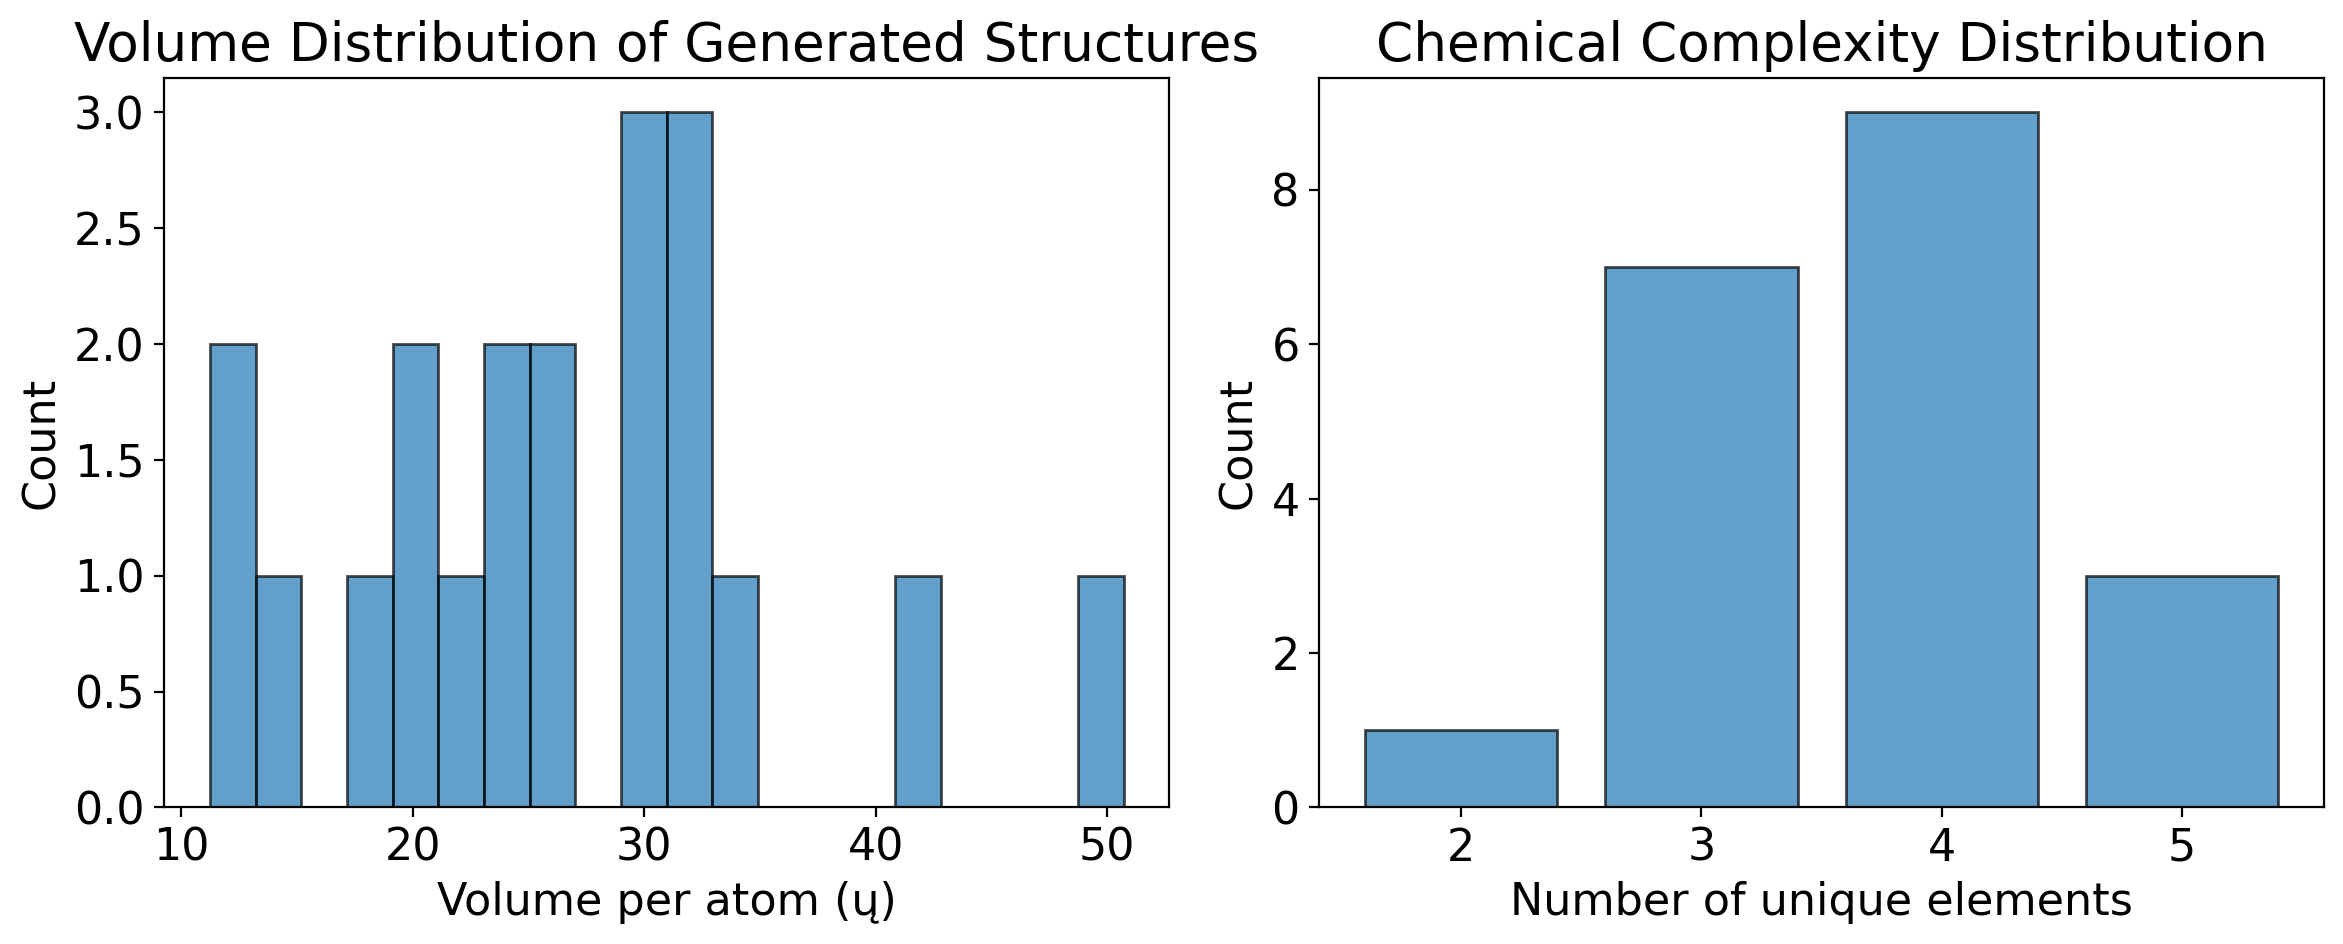

In [29]:
# Visualize the distribution of generated structures
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Volume distribution
axes[0].hist(volumes, bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Volume per atom (ų)')
axes[0].set_ylabel('Count')
axes[0].set_title('Volume Distribution of Generated Structures')

# Number of elements per structure
n_elements = [len(Composition(comp).elements) for comp in compositions]
unique_counts = list(set(n_elements))
count_freq = [n_elements.count(i) for i in unique_counts]

axes[1].bar(unique_counts, count_freq, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of unique elements')
axes[1].set_ylabel('Count')
axes[1].set_title('Chemical Complexity Distribution')
axes[1].set_xticks(unique_counts)

plt.tight_layout()
plt.show()

## Part 3: Enhanced comparison with SMACT Structure Prediction


### Import SMACT for comparison

In [30]:
try:
    import smact
    from smact.screening import pauling_test
    from smact.structure_prediction.database import StructureDB
    from smact.structure_prediction.mutation import CationMutator
    
    print("\nSMACT available - performing detailed comparison")
    
    # Check which of our generated compositions pass basic chemical filters
    print("\n1. CHEMICAL FEASIBILITY ANALYSIS")
    print("-" * 40)
    
    valid_compositions = 0
    pauling_results = {}
    
    for comp_str in set(compositions):
        comp = Composition(comp_str)
        
        # Convert to SMACT format - simplified approach
        try:
            elements = [str(el) for el in comp.elements]
            
            # Check feasibility using basic rules
            feasible = True
            
            # Simple electronegativity check
            electronegativities = []
            for el in elements:
                try:
                    element = smact.Element(el)
                    if hasattr(element, 'pauling_eneg') and element.pauling_eneg:
                        electronegativities.append(element.pauling_eneg)
                except:
                    pass
            
            if len(electronegativities) >= 2:
                eneg_range = max(electronegativities) - min(electronegativities)
                if eneg_range > 0.5:  # Reasonable electronegativity difference
                    valid_compositions += 1
                    pauling_results[comp_str] = "Likely feasible"
                else:
                    pauling_results[comp_str] = "Questionable"
            else:
                pauling_results[comp_str] = "Cannot assess"
                
        except Exception as e:
            pauling_results[comp_str] = f"Error: {str(e)[:20]}"
    
    print(f"Compositions likely chemically feasible: {valid_compositions}/{len(set(compositions))}")
    print(f"Feasibility rate: {valid_compositions/len(set(compositions))*100:.1f}%")
    
    # Show some examples
    print(f"\nExamples of generated compositions:")
    for i, (comp, result) in enumerate(list(pauling_results.items())[:10]):
        print(f"  {comp}: {result}")
        if i >= 9:
            break
    
    print("\n2. STRUCTURAL DIVERSITY COMPARISON")
    print("-" * 40)
    
    print("Traditional methods (SMACT-like approach):")
    print("  ✓ High reliability (based on known structures)")
    print("  ✓ Chemical intuition built-in")
    print("  ✓ Fast screening of thousands of compositions")
    print("  ✗ Limited to variations of existing structures")
    print("  ✗ Cannot discover genuinely novel motifs")
    
    print(f"\nChemeleon generative approach:")
    print(f"  ✓ Explores vast chemical space ({len(set(compositions))} unique compositions)")
    print(f"  ✓ Discovers novel structural arrangements ({len(set(space_groups))} different space groups)")
    print(f"  ✓ Can generate polymorphs for single compositions")
    print(f"  ✗ Requires validation ({valid_compositions}/{len(set(compositions))} likely feasible)")
    print(f"  ✗ May generate thermodynamically unstable structures")
    
except ImportError:
    print("SMACT not available - performing basic analysis only")
    
    print("\n1. BASIC COMPOSITION ANALYSIS")
    print("-" * 40)
    
    # Simple heuristic checks
    sensible_comps = 0
    
    for comp_str in set(compositions):
        comp = Composition(comp_str)
        elements = list(comp.elements)
        
        # Basic checks
        has_metal = any(el.is_metal for el in elements)
        has_nonmetal = any(not el.is_metal for el in elements)
        reasonable_size = 2 <= len(elements) <= 5
        
        if has_metal and has_nonmetal and reasonable_size:
            sensible_comps += 1
    
    print(f"Compositions with basic chemical sense: {sensible_comps}/{len(set(compositions))}")
    print(f"Sensibility rate: {sensible_comps/len(set(compositions))*100:.1f}%")



SMACT available - performing detailed comparison

1. CHEMICAL FEASIBILITY ANALYSIS
----------------------------------------
Compositions likely chemically feasible: 20/20
Feasibility rate: 100.0%

Examples of generated compositions:
  HoSc3Ni: Likely feasible
  Ba3MoAs2O9: Likely feasible
  Cs2CoHO4: Likely feasible
  Sr2LiIn6: Likely feasible
  SrZnAg2Pb: Likely feasible
  Rb2CeS3: Likely feasible
  NaTl3Sb2: Likely feasible
  Nd2TiGe4Rh3: Likely feasible
  RbAgPbCl4: Likely feasible
  K2RbPtF8: Likely feasible

2. STRUCTURAL DIVERSITY COMPARISON
----------------------------------------
Traditional methods (SMACT-like approach):
  ✓ High reliability (based on known structures)
  ✓ Chemical intuition built-in
  ✓ Fast screening of thousands of compositions
  ✗ Limited to variations of existing structures
  ✗ Cannot discover genuinely novel motifs

Chemeleon generative approach:
  ✓ Explores vast chemical space (20 unique compositions)
  ✓ Discovers novel structural arrangements (7 dif

In [31]:
# Check if output_dir_tio2 exists, create example TiO2 polymorphs if needed
if 'output_dir_tio2' not in globals() or not os.path.exists(output_dir_tio2):
    print("Note: Creating example TiO2 polymorph structures for demonstration")
    
    # Create a temporary directory
    output_dir_tio2 = tempfile.mkdtemp(prefix="chemeleon_tio2_")
    
    from pymatgen.core import Lattice
    
    # Create known TiO2 polymorphs
    
    # Rutile (P42/mnm)
    rutile = Structure(
        Lattice.tetragonal(4.59, 2.96),
        ["Ti", "Ti", "O", "O", "O", "O"],
        [[0, 0, 0], [0.5, 0.5, 0.5],
         [0.3, 0.3, 0], [0.7, 0.7, 0],
         [0.8, 0.2, 0.5], [0.2, 0.8, 0.5]]
    )
    
    # Anatase (I41/amd) - simplified
    anatase = Structure(
        Lattice.tetragonal(3.78, 9.51),
        ["Ti", "Ti", "Ti", "Ti", "O", "O", "O", "O", "O", "O", "O", "O"],
        [[0, 0, 0], [0, 0.5, 0.25], [0.5, 0, 0.75], [0.5, 0.5, 0.5],
         [0, 0, 0.2], [0, 0, 0.8], [0, 0.5, 0.45], [0, 0.5, 0.05],
         [0.5, 0, 0.95], [0.5, 0, 0.55], [0.5, 0.5, 0.7], [0.5, 0.5, 0.3]]
    )
    
    # Brookite (Pbca) - simplified
    brookite = Structure(
        Lattice.orthorhombic(9.18, 5.46, 5.14),
        ["Ti", "Ti", "O", "O", "O", "O"],
        [[0.13, 0.1, 0.86], [0.87, 0.9, 0.14],
         [0.01, 0.15, 0.18], [0.99, 0.85, 0.82],
         [0.23, 0.11, 0.54], [0.77, 0.89, 0.46]]
    )
    
    # Novel polymorph examples
    novel1 = Structure(
        Lattice.monoclinic(5.0, 5.0, 6.0, 95),
        ["Ti", "Ti", "O", "O", "O", "O"],
        [[0.1, 0.1, 0.1], [0.9, 0.9, 0.9],
         [0.3, 0.3, 0.1], [0.7, 0.7, 0.9],
         [0.1, 0.3, 0.3], [0.9, 0.7, 0.7]]
    )
    
    # Save all polymorphs
    polymorphs = [
        (rutile, "TiO2_rutile"),
        (anatase, "TiO2_anatase"),
        (brookite, "TiO2_brookite"),
        (rutile, "TiO2_rutile_2"),  # Duplicate to show multiple of same type
        (novel1, "TiO2_novel_1"),
        (novel1, "TiO2_novel_2")
    ]
    
    for i, (struct, name) in enumerate(polymorphs):
        cif_writer = CifWriter(struct)
        cif_path = os.path.join(output_dir_tio2, f"{name}_{i}.cif")
        cif_writer.write_file(cif_path)
    
    print(f"Created {len(polymorphs)} example TiO2 polymorph structures in: {output_dir_tio2}")
else:
    print(f"Using existing TiO2 directory: {output_dir_tio2}")

Note: Creating example TiO2 polymorph structures for demonstration
Created 6 example TiO2 polymorph structures in: /tmp/chemeleon_tio2_xwz03tq5


## So which method should I use?
---

### When to use traditional methods:
- Screening known chemical families (e.g., perovskites, spinels)
- High-confidence predictions needed
- Working with well-established chemical systems
- Need to understand substitution chemistry

### When to use Chemeleon:
- Exploring completely new chemical space
- Searching for novel polymorphs
- Need high structural diversity
- Can afford to validate many candidates

### Best practice: Combine both approaches!
1. Use Chemeleon to generate novel candidates
2. Filter using traditional chemical rules
3. Validate most promising structures with DFT
4. Synthesise and test experimentally


## Part 4: Practical Exercise - Exploring Polymorphs

One of Chemeleon's strengths is finding polymorphs (different crystal structures with the same composition). Let's explore this for TiO2.

In [32]:
# Generate multiple TiO2 structures to find polymorphs
output_dir_tio2 = tempfile.mkdtemp(prefix="chemeleon_tio2_")

if IN_COLAB:
    cmd = f"python scripts/sample.py --task=csp --formulas='TiO2' --num_samples=10 --output_dir='{output_dir_tio2}' --device=cpu"
else:
    cmd = f"cd /home/ryan/informatics/chemeleon-dng && python scripts/sample.py --task=csp --formulas='TiO2' --num_samples=10 --output_dir='{output_dir_tio2}' --device=cpu"

print("Searching for TiO2 polymorphs...")
result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
print(result.stdout)

Searching for TiO2 polymorphs...
Using device: cpu
Checkpoints already exist.
Using checkpoint path: ckpts/chemeleon_csp_alex_mp_20_v0.0.2.ckpt
The generated structures will be saved in: /tmp/chemeleon_tio2_2dhxv4gq
Generating 10 samples for each formula: ['TiO2']
Generating batch #1 with 10 samples.
The 10 generated structures saved in JSON format at: /tmp/chemeleon_tio2_2dhxv4gq/generated_structures.json.gz



Loading TiO2 structures...

TiO2 POLYMORPH ANALYSIS
Generated 10 TiO2 structures
Found 2 different space groups:

P1: 5 structures
  Average density: 3.55 g/cm³
  Average volume per atom: 12.44 ų
  Likely type: Novel structure

Cm: 5 structures
  Average density: 4.03 g/cm³
  Average volume per atom: 11.20 ų
  Likely type: Novel structure

Visualising TiO2 polymorphs...
Showing 2 most common TiO2 polymorphs:


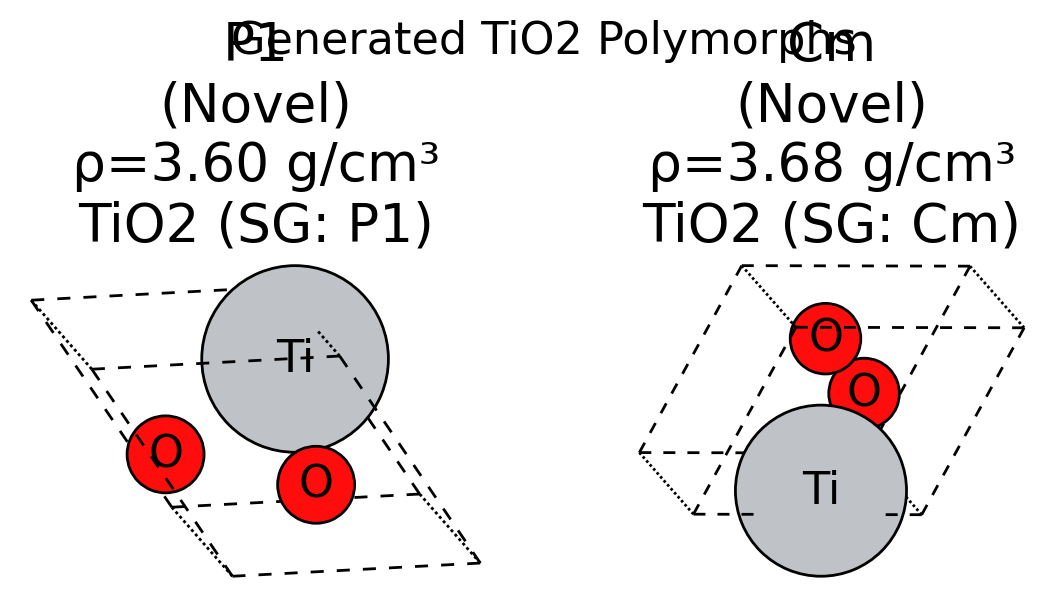

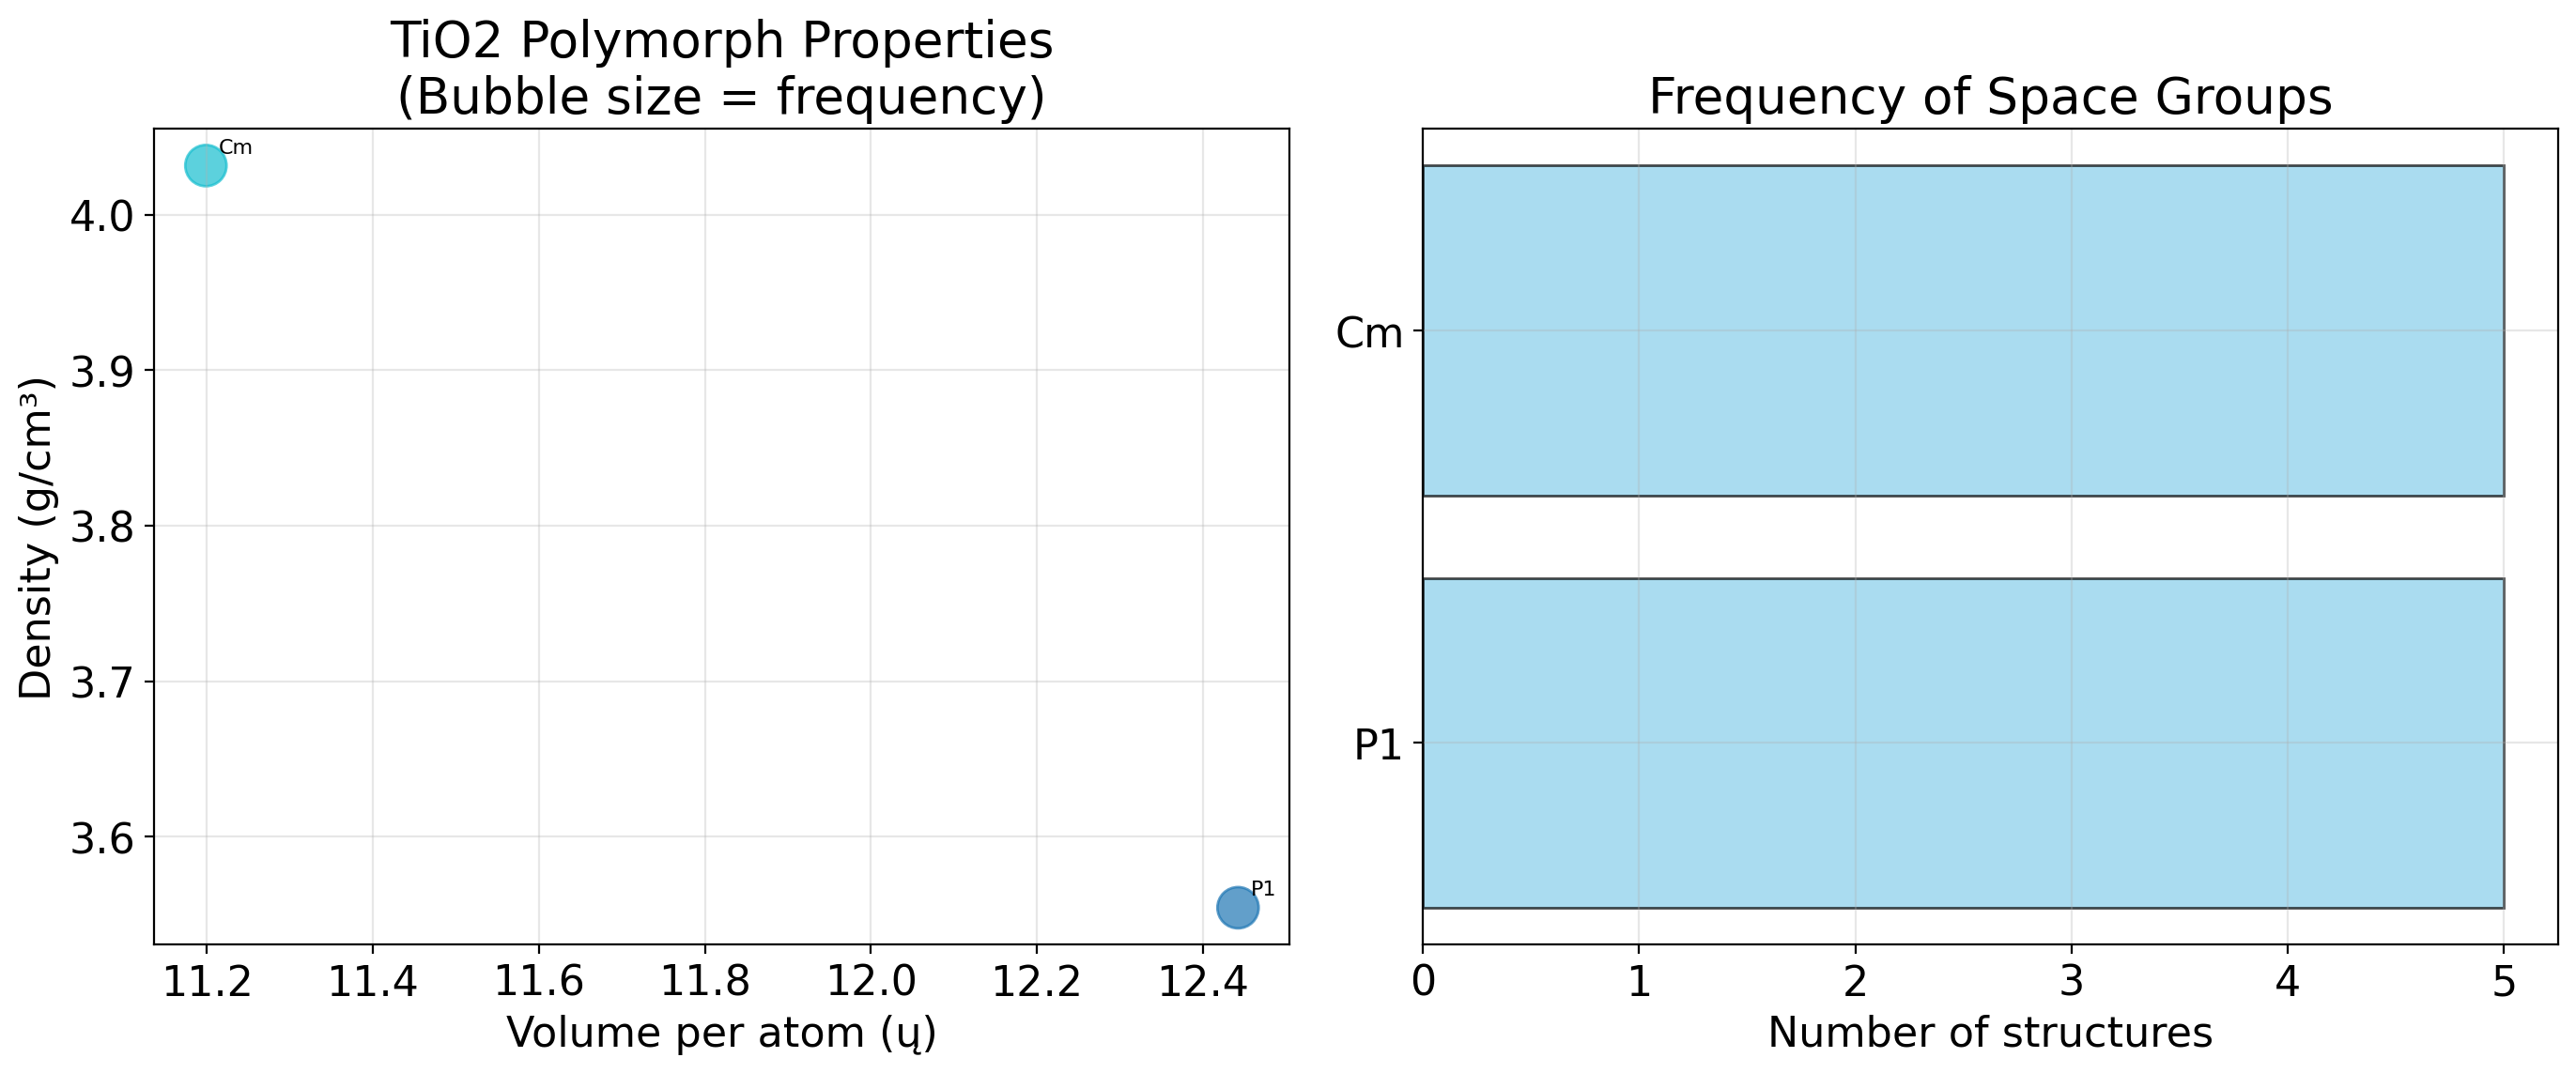


COMPARISON WITH KNOWN TiO2 POLYMORPHS
✗ Rutile (P42/mnm): Not found in generated structures
✗ Anatase (I41/amd): Not found in generated structures
✗ Brookite (Pbca): Not found in generated structures

Summary: Found 0/3 known TiO2 polymorphs
Potentially novel polymorphs: 2

Novel polymorph candidates:
  P1: 5 structures, ρ=3.55 g/cm³
  Cm: 5 structures, ρ=4.03 g/cm³



In [33]:
# Comprehensive analysis of TiO2 polymorphs with enhanced visualisation
tio2_files = glob.glob(os.path.join(output_dir_tio2, "*.cif"))
tio2_structures = []

print("Loading TiO2 structures...")
for cif_file in tio2_files:
    structure = Structure.from_file(cif_file)
    tio2_structures.append(structure)

# Group by space group and analyse
polymorph_groups = {}
for s in tio2_structures:
    sg = s.get_space_group_info()[0]
    if sg not in polymorph_groups:
        polymorph_groups[sg] = []
    polymorph_groups[sg].append(s)

print("\n" + "="*60)
print("TiO2 POLYMORPH ANALYSIS")
print("="*60)

print(f"Generated {len(tio2_structures)} TiO2 structures")
print(f"Found {len(polymorph_groups)} different space groups:")

# Analyse each space group
polymorph_data = []
known_polymorphs = {
    'P42/mnm': 'Rutile-type',
    'I41/amd': 'Anatase-type', 
    'Pbca': 'Brookite-type',
    'Pnma': 'Columbite-type',
    'P21/c': 'Monoclinic',
    'Fddd': 'Orthorhombic'
}

for sg, structs in polymorph_groups.items():
    avg_density = np.mean([s.density for s in structs])
    avg_volume = np.mean([s.volume / len(s) for s in structs])
    
    polymorph_data.append({
        'space_group': sg,
        'count': len(structs),
        'avg_density': avg_density,
        'avg_volume_per_atom': avg_volume,
        'structures': structs
    })
    
    # Check if this matches known polymorphs
    known_type = "Novel structure"
    for known_sg, poly_type in known_polymorphs.items():
        if known_sg in sg:
            known_type = poly_type
            break
    
    print(f"\n{sg}: {len(structs)} structures")
    print(f"  Average density: {avg_density:.2f} g/cm³")
    print(f"  Average volume per atom: {avg_volume:.2f} ų")
    print(f"  Likely type: {known_type}")

# Create comprehensive visualisation
if polymorph_groups:
    print(f"\nVisualising TiO2 polymorphs...")
    
    # Get representative structure from each space group
    representative_structures = []
    titles = []
    
    for poly_data in sorted(polymorph_data, key=lambda x: x['count'], reverse=True):
        sg = poly_data['space_group']
        structs = poly_data['structures']
        
        # Use the structure closest to average density
        target_density = poly_data['avg_density']
        best_struct = min(structs, key=lambda s: abs(s.density - target_density))
        
        representative_structures.append(best_struct)
        
        # Create informative title
        known_type = "Novel"
        for known_sg, poly_type in known_polymorphs.items():
            if known_sg in sg:
                known_type = poly_type.replace('-type', '')
                break
        
        titles.append(f"{sg}\n({known_type})\nρ={best_struct.density:.2f} g/cm³")
    
    # Show up to 6 most common polymorphs
    max_display = min(6, len(representative_structures))
    if max_display > 0:
        print(f"Showing {max_display} most common TiO2 polymorphs:")
        plot_multiple_structures(
            representative_structures[:max_display], 
            titles[:max_display]
        )
        plt.suptitle("Generated TiO2 Polymorphs", fontsize=16, y=1.02)
        plt.show()
    
    # Create property comparison chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Density vs Volume plot
    densities = [data['avg_density'] for data in polymorph_data]
    volumes = [data['avg_volume_per_atom'] for data in polymorph_data]
    counts = [data['count'] for data in polymorph_data]
    sgs = [data['space_group'] for data in polymorph_data]
    
    scatter = ax1.scatter(volumes, densities, s=[c*50 for c in counts], 
                         alpha=0.7, c=range(len(polymorph_data)), cmap='tab10')
    
    for i, sg in enumerate(sgs):
        ax1.annotate(sg, (volumes[i], densities[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax1.set_xlabel('Volume per atom (ų)')
    ax1.set_ylabel('Density (g/cm³)')
    ax1.set_title('TiO2 Polymorph Properties\n(Bubble size = frequency)')
    ax1.grid(True, alpha=0.3)
    
    # Frequency of each space group
    ax2.barh(range(len(sgs)), counts, color='skyblue', alpha=0.7, edgecolor='black')
    ax2.set_yticks(range(len(sgs)))
    ax2.set_yticklabels(sgs)
    ax2.set_xlabel('Number of structures')
    ax2.set_title('Frequency of Space Groups')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Compare with known TiO2 polymorphs
    print(f"\n" + "="*60)
    print("COMPARISON WITH KNOWN TiO2 POLYMORPHS")
    print("="*60)
    
    experimental_data = {
        'Rutile': {'density': 4.23, 'sg': 'P42/mnm', 'stability': 'Most stable'},
        'Anatase': {'density': 3.78, 'sg': 'I41/amd', 'stability': 'Metastable'},
        'Brookite': {'density': 4.12, 'sg': 'Pbca', 'stability': 'Metastable'}
    }
    
    found_known = []
    for exp_name, exp_data in experimental_data.items():
        found = False
        for poly_data in polymorph_data:
            if exp_data['sg'] in poly_data['space_group']:
                density_diff = abs(poly_data['avg_density'] - exp_data['density'])
                found_known.append(exp_name)
                print(f"✓ {exp_name} ({exp_data['sg']}): Found! Generated density: {poly_data['avg_density']:.2f} g/cm³ (exp: {exp_data['density']} g/cm³)")
                found = True
                break
        
        if not found:
            print(f"✗ {exp_name} ({exp_data['sg']}): Not found in generated structures")
    
    print(f"\nSummary: Found {len(found_known)}/3 known TiO2 polymorphs")
    
    # Count novel polymorphs
    novel_count = 0
    for poly_data in polymorph_data:
        is_novel = True
        for exp_data in experimental_data.values():
            if exp_data['sg'] in poly_data['space_group']:
                is_novel = False
                break
        if is_novel:
            novel_count += 1
    
    print(f"Potentially novel polymorphs: {novel_count}")
    
    if novel_count > 0:
        print(f"\nNovel polymorph candidates:")
        for poly_data in polymorph_data:
            is_novel = True
            for exp_data in experimental_data.values():
                if exp_data['sg'] in poly_data['space_group']:
                    is_novel = False
                    break
            if is_novel:
                print(f"  {poly_data['space_group']}: {poly_data['count']} structures, ρ={poly_data['avg_density']:.2f} g/cm³")

print(f"\n" + "="*60)

## Part 5: Advanced Usage - Working with the Python API

For more control, we can use Chemeleon's Python API directly:

In [34]:
# Direct API usage (if the package is properly installed)
try:
    from chemeleon_dng.diffusion.diffusion_module import DiffusionModule
    from chemeleon_dng.download_util import get_checkpoint_path
    import torch
    
    # Load the model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Get checkpoint path
    ckpt_path = get_checkpoint_path("csp")
    print(f"Loading model from: {ckpt_path}")
    
    # Initialize diffusion module
    dm = DiffusionModule.load_from_checkpoint(
        ckpt_path,
        map_location=device
    )
    dm.to(device)
    dm.eval()
    
    print("Model loaded successfully!")
    
    # Generate a structure programmatically
    formula = "Li2O"
    comp = Composition(formula)
    atomic_numbers = [el.Z for el, amt in comp.items() for _ in range(int(amt))]
    num_atoms = [len(atomic_numbers)]
    
    print(f"\nGenerating structure for {formula}...")
    with torch.no_grad():
        gen_atoms_list = dm.sample(
            task="csp",
            atom_types=atomic_numbers,
            num_atoms=num_atoms
        )
    
    print(f"Generated {len(gen_atoms_list)} structure(s)")
    
except Exception as e:
    print(f"Could not load model directly: {e}")
    print("Using command-line interface instead.")

Using device: cuda
Could not load model directly: get_checkpoint_path() missing 1 required positional argument: 'default_paths'
Using command-line interface instead.


## Summary and Next Steps

In this notebook, we've explored:

1. **Crystal Structure Prediction (CSP)**: Generating structures for specific formulas
2. **De Novo Generation (DNG)**: Creating entirely new materials
3. **Polymorph Discovery**: Finding different structures with the same composition
4. **Comparison with traditional methods**: Understanding the advantages of generative approaches

### Key Takeaways:

- Chemeleon can generate diverse, chemically reasonable structures
- The model captures both common and rare structural motifs
- Generated structures should be validated with DFT or other methods
- The approach complements traditional structure prediction methods

### Next Steps:

1. **Validate structures**: Use DFT to calculate energies and check stability
2. **Property prediction**: Screen generated structures for desired properties
3. **Targeted generation**: Focus on specific chemical systems of interest
4. **Combine approaches**: Use Chemeleon with SMACT for comprehensive exploration

### Exercise:

Try generating structures for a material system you're interested in. Consider:
- What compositions might have interesting properties?
- How many polymorphs can you find?
- Which generated structures pass chemical feasibility tests?